The code is adopted from the public kernel

## Objectives
- This notebook tries to use 5 different clusters to train different model (here, we only train one specific model for one specific cluster, which shows pretty low RMSE in the validation.

## Knowledge points
- Using save_npz to save the scipy's sparse matrix




In [ ]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import pickle
print("Data:\n",os.listdir("../data"))

In [2]:
# import sys
# # the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
# sys.path.append('/home/user/san/project_p/LightGBM/python-package/')

import lightgbm as lgb

In [9]:
# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold
from sklearn.model_selection import StratifiedKFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
NFOLDS = 5
SEED = 42
VALID = True
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [3]:
print("\nData Load Stage")
training = pd.read_csv('../data/train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing_set = pd.read_csv('../data/test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing_set.index


Data Load Stage


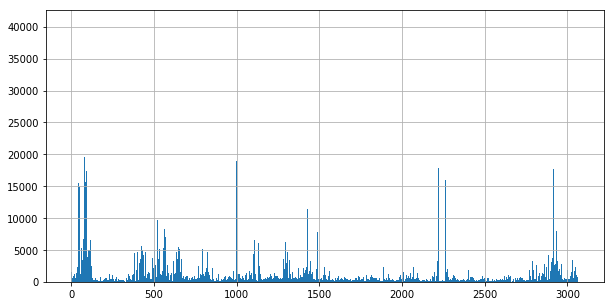

In [7]:
training.image_top_1.hist(bins=1000, figsize=(10,5))

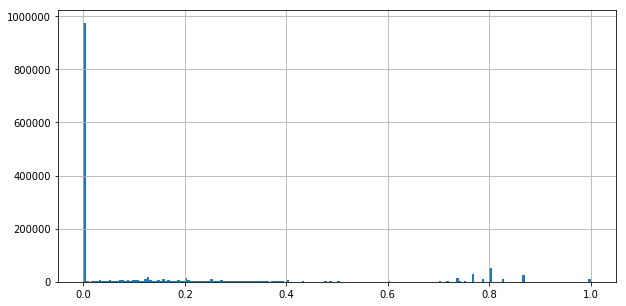

In [5]:
training.deal_probability.hist(bins=200, figsize=(10,5))

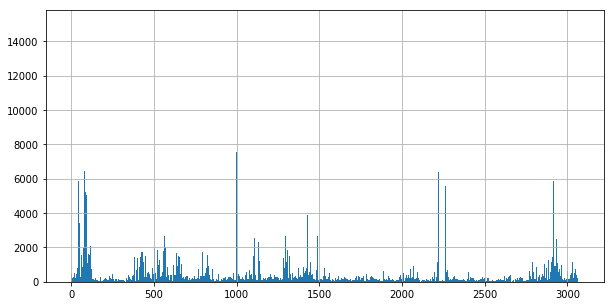

In [18]:
testing_set.image_top_1.hist(bins=1000, figsize=(10,5))

In [14]:
ntrain = training.shape[0]
ntest = testing_set.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing_set.shape))

print("Combine Train and Test")
df = pd.concat([training,testing_set],axis=0)
# del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [15]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

Feature Engineering

Create Time Variables

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


### Label Encoding for all categorical columnsm

In [16]:
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


Text Features

[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [26]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])


In [27]:
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

FeatureUnion(n_jobs=1,
       transformer_list=[('description', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float32'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=17000, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preproces...   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None))],
       transformer_weights=None)

# Create different ready_df for clusters

In [15]:
with open('../data/training_total_item_id_new.pkl', 'rb') as file_output:
    total_item_id = pickle.load(file_output)

with open('../data/testing_total_item_id_new.pkl', 'rb') as file_output:
    testing_total_item_id = pickle.load(file_output)

In [22]:
# create 10 clusters, 5 for training, 5 for testing
print(df[df.index.isin(total_item_id[0])].shape)
print(df[df.index.isin(total_item_id[1])].shape)
print(df[df.index.isin(total_item_id[2])].shape)
print(df[df.index.isin(total_item_id[3])].shape)
print(df[df.index.isin(total_item_id[4])].shape)
print('total: ', 542743 +170548 +115093 +232474 +441502)

(542743, 25)
(170548, 25)
(115093, 25)
(232474, 25)
(441502, 25)
total:  1502360


In [31]:
# create 10 clusters, 5 for training, 5 for testing
print(df[df.index.isin(total_item_id[0])].shape)
print(df[df.index.isin(total_item_id[1])].shape)
print(df[df.index.isin(total_item_id[2])].shape)
print(df[df.index.isin(total_item_id[3])].shape)
print(df[df.index.isin(total_item_id[4])].shape)

(540516, 25)
(171936, 25)
(116256, 25)
(232912, 25)
(441804, 25)


In [32]:
ready_df_train_1 = vectorizer.transform(df[df.index.isin(total_item_id[0])].to_dict('records'))
ready_df_train_2 = vectorizer.transform(df[df.index.isin(total_item_id[1])].to_dict('records'))
ready_df_train_3 = vectorizer.transform(df[df.index.isin(total_item_id[2])].to_dict('records'))
ready_df_train_4 = vectorizer.transform(df[df.index.isin(total_item_id[3])].to_dict('records'))
ready_df_train_5 = vectorizer.transform(df[df.index.isin(total_item_id[4])].to_dict('records'))

In [34]:
# for test set
print(df[df.index.isin(testing_total_item_id[0])].shape)
print(df[df.index.isin(testing_total_item_id[1])].shape)
print(df[df.index.isin(testing_total_item_id[2])].shape)
print(df[df.index.isin(testing_total_item_id[3])].shape)
print(df[df.index.isin(testing_total_item_id[4])].shape)
print('total for test: ', df[df.index.isin(testing_total_item_id[0])].shape[0] + df[df.index.isin(testing_total_item_id[1])].shape[1] + df[df.index.isin(testing_total_item_id[2])].shape[1] + df[df.index.isin(testing_total_item_id[3])].shape[1] + df[df.index.isin(testing_total_item_id[4])].shape[1])

(201071, 25)
(61329, 25)
(39875, 25)
(70131, 25)
(136031, 25)
total for test:  201171


In [35]:
ready_df_test_1 = vectorizer.transform(df[df.index.isin(testing_total_item_id[0])].to_dict('records'))
ready_df_test_2 = vectorizer.transform(df[df.index.isin(testing_total_item_id[1])].to_dict('records'))
ready_df_test_3 = vectorizer.transform(df[df.index.isin(testing_total_item_id[2])].to_dict('records'))
ready_df_test_4 = vectorizer.transform(df[df.index.isin(testing_total_item_id[3])].to_dict('records'))
ready_df_test_5 = vectorizer.transform(df[df.index.isin(testing_total_item_id[4])].to_dict('records'))

## Using save_npz to save the scipy's sparse matrix

In [36]:
# save all
from scipy import sparse

sparse.save_npz('../data/ready_df_train_1.hdf', ready_df_train_1)
sparse.save_npz('../data/ready_df_train_2.hdf', ready_df_train_2)
sparse.save_npz('../data/ready_df_train_3.hdf', ready_df_train_3)
sparse.save_npz('../data/ready_df_train_4.hdf', ready_df_train_4)
sparse.save_npz('../data/ready_df_train_5.hdf', ready_df_train_5)

sparse.save_npz('../data/ready_df_test_1.hdf', ready_df_test_1)
sparse.save_npz('../data/ready_df_test_2.hdf', ready_df_test_2)
sparse.save_npz('../data/ready_df_test_3.hdf', ready_df_test_3)
sparse.save_npz('../data/ready_df_test_4.hdf', ready_df_test_4)
sparse.save_npz('../data/ready_df_test_5.hdf', ready_df_test_5)

## Load all cluster

In [5]:
# save all
from scipy import sparse

ready_df_train_1 = sparse.load_npz("../data/ready_df_train_1.hdf.npz")
ready_df_train_2 = sparse.load_npz("../data/ready_df_train_2.hdf.npz")
ready_df_train_3 = sparse.load_npz("../data/ready_df_train_3.hdf.npz")
ready_df_train_4 = sparse.load_npz("../data/ready_df_train_4.hdf.npz")
ready_df_train_5 = sparse.load_npz("../data/ready_df_train_5.hdf.npz")

In [6]:
ready_df_test_1 = sparse.load_npz("../data/ready_df_test_1.hdf.npz")
ready_df_test_2 = sparse.load_npz("../data/ready_df_test_2.hdf.npz")
ready_df_test_3 = sparse.load_npz("../data/ready_df_test_3.hdf.npz")
ready_df_test_4 = sparse.load_npz("../data/ready_df_test_4.hdf.npz")
ready_df_test_5 = sparse.load_npz("../data/ready_df_test_5.hdf.npz")

### finished making clustered Ready_df

In [10]:
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

Vectorization Runtime: 10.02 Minutes


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23034390282097936


In [12]:
print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

Modeling Stage


## Save ready_df and df

In [ ]:
# from scipy import sparse

# sparse.save_npz('/media/data/avito/preprocessed/ready_df_02222.hdf', ready_df)

# df.to_hdf('/media/data/avito/preprocessed/df_02222.hdf', key='table')

# import pickle

# with open('/media/data/avito/preprocessed/traindex.pkl', 'wb') as file_output:
#     pickle.dump(traindex, file_output, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('/media/data/avito/preprocessed/testdex.pkl', 'wb') as file_output:
#     pickle.dump(testdex, file_output, protocol=pickle.HIGHEST_PROTOCOL)

## Load read_df, df, traindex, testdex & tfvocab

In [7]:
from scipy import sparse

## The SVD TFIDF
# ready_df = np.load('..data/ready_df_svd.npy')

## Original TFIDF
# ready_df = sparse.load_npz("../data/ready_df_02222.hdf.npz")

df = pd.read_hdf('../data/df_02222.hdf', key='table')

with open('../data/traindex.pkl', 'rb') as file_output:
    traindex = pickle.load(file_output)
with open('../data/testdex.pkl', 'rb') as file_output:
    testdex = pickle.load(file_output)
with open('../data/df_tfvocab_pub_ker.pkl', 'rb') as file_output:
    tfvocab = pickle.load(file_output)
    
y = pd.read_hdf('../data/y.hdf', key='table')

## load image features

categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]

In [8]:
df_train_img_feat = pd.read_hdf('../data/df_train_img_feat.hdf', key='table')
df_test_img_feat = pd.read_hdf('../data/df_test_img_feat.hdf', key='table')

print("Image Feature: Combine Train and Test")
df_img_feat = pd.concat([df_train_img_feat,df_test_img_feat], axis=0)
print(df_img_feat.shape)

# Add .jpg
df.image = df.image + '.jpg'

# Review added .jpg
print(df.image[0])
print(df_img_feat.shape)

df = df.reset_index().merge(df_img_feat, on='image', how="left").set_index(df.index.names)
print(df.shape)

# del df_train_img_feat; del df_test_img_feat; del df_img_feat

Image Feature: Combine Train and Test
(1856661, 9)
d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c7679f17c333c959b19.jpg
(1856661, 9)
(2011862, 32)


In [9]:
with open('../data/df_pong.pkl', 'rb') as file_output:
    df_pong = pickle.load(file_output)

useful_list_from_pong = ['category_name_one_ratio',
                         'category_name_zero_ratio',
                         'category_name_score_lower_extreme',
                        'category_name_score_upper_extreme',
                            'city_one_ratio',
                             'city_zero_ratio',
                             'image_top_1_one_ratio',
                             'image_top_1_zero_ratio',
                         'param_1_one_ratio', 
                           'param_1_score_lower_extreme',
                         'param_1_score_upper_extreme',
                           'param_1_zero_ratio',  'param_1_score',
                         'param_2_one_ratio',
                         'param_2_score_lower_extreme','param_2_score_upper_extreme',
                         'param_2_zero_ratio',  'param_2_score',
                       'param_3_one_ratio', 'param_3_score',
                       'param_3_score_lower_extreme', 'param_3_score_upper_extreme',
                        'param_3_zero_ratio',
        'region_one_ratio', 'region_zero_ratio', 
     'user_type_one_ratio','user_type_zero_ratio']

df_pong_useful = df_pong[useful_list_from_pong]

In [10]:
df_pong_useful.shape

(2011862, 27)

In [11]:
df = df.merge(df_pong_useful, how='left', right_index=True, left_index=True).set_index(df.index)

In [12]:
# remove useless features

df.drop(['image', 'Weekd of Year', 'Day of Month'], axis=1, inplace=True)

## Split into 5 clusters (by img_top_1)

In [13]:
tfvocab = df.columns.tolist() + tfvocab

print("Feature Names Length: ",len(tfvocab))

Feature Names Length:  1430816


In [90]:
# with open('../data/df_pong.pkl', 'rb') as file_output:
#     df_pong = pickle.load(file_output)

test_pong = df_pong.loc[testdex]

# def get_quantiles(k):
#     group_zero_ratio = test_pong.groupby('image_top_1')['image_top_1_zero_ratio'].unique().apply(lambda n : n[0])
#     quantiles = group_zero_ratio.quantile([0., 0.2, 0.4, 0.6, 0.8, 1])
    
#     return test_pong[test_pong['image_top_1'].isin(group_zero_ratio[(group_zero_ratio > quantiles.iloc[k]) & (group_zero_ratio < quantiles.iloc[k+1])].index)].index

# selected_index_test_ONE = df_index[df_index.item_id.isin(get_quantiles(0))].index
# selected_index_test_TWO = df_index[df_index.item_id.isin(get_quantiles(1))].index
# selected_index_test_THREE = df_index[df_index.item_id.isin(get_quantiles(2))].index
# selected_index_test_FOUR = df_index[df_index.item_id.isin(get_quantiles(3))].index
# selected_index_test_FIVE = df_index[df_index.item_id.isin(get_quantiles(4))].index

In [16]:
### ONE ###
# Combine Dense Features with Sparse Text Bag of Words Features
X_1 = hstack([csr_matrix(df.loc[total_item_id[0],:].values),ready_df_train_1]) # Sparse Matrix
print("{} Rows and {} Cols".format(X_1.shape[0], X_1.shape[1]))

testing_1 = hstack([csr_matrix(df.loc[testing_total_item_id[0],:].values),ready_df_test_1])
print("{} Rows and {} Cols".format(testing_1.shape[0], testing_1.shape[1]))

y_1 = y.loc[total_item_id[0]]
y_4_bins_1 = pd.cut(y_1, [-0.01,0.01,0.163, 0.76, 1], labels=['0', '0.01', '0.163', '0.76'], right=True)
print('y len is:', len(y_4_bins_1))

540516 Rows and 1430816 Cols
201071 Rows and 1430816 Cols
y len is: 540516


In [17]:
### TWO ###
# Combine Dense Features with Sparse Text Bag of Words Features
X_2 = hstack([csr_matrix(df.loc[total_item_id[1],:].values),ready_df_train_2]) # Sparse Matrix
print("{} Rows and {} Cols".format(X_2.shape[0], X_2.shape[1]))

testing_2 = hstack([csr_matrix(df.loc[testing_total_item_id[1],:].values),ready_df_test_2])
print("{} Rows and {} Cols".format(testing_2.shape[0], testing_2.shape[1]))

y_2 = y.loc[total_item_id[1]]
y_4_bins_2 = pd.cut(y_2, [-0.01,0.01,0.163, 0.76, 1], labels=['0', '0.01', '0.163', '0.76'], right=True)
print('y len is:', len(y_4_bins_2))

171936 Rows and 1430816 Cols
61329 Rows and 1430816 Cols
y len is: 171936


In [18]:
### THREE ###
# Combine Dense Features with Sparse Text Bag of Words Features
X_3 = hstack([csr_matrix(df.loc[total_item_id[2],:].values),ready_df_train_3]) # Sparse Matrix
print("{} Rows and {} Cols".format(X_3.shape[0], X_3.shape[1]))

testing_3 = hstack([csr_matrix(df.loc[testing_total_item_id[2],:].values),ready_df_test_3])
print("{} Rows and {} Cols".format(testing_3.shape[0], testing_3.shape[1]))

y_3 = y.loc[total_item_id[2]]
y_4_bins_3 = pd.cut(y_3, [-0.01,0.01,0.163, 0.76, 1], labels=['0', '0.01', '0.163', '0.76'], right=True)
print('y len is:', len(y_4_bins_3))

116256 Rows and 1430816 Cols
39875 Rows and 1430816 Cols
y len is: 116256


In [19]:
### FOUR ###
# Combine Dense Features with Sparse Text Bag of Words Features
X_4 = hstack([csr_matrix(df.loc[total_item_id[3],:].values),ready_df_train_4]) # Sparse Matrix
print("{} Rows and {} Cols".format(X_4.shape[0], X_4.shape[1]))

testing_4 = hstack([csr_matrix(df.loc[testing_total_item_id[3],:].values),ready_df_test_4])
print("{} Rows and {} Cols".format(testing_4.shape[0], testing_4.shape[1]))

y_4 = y.loc[total_item_id[3]]
y_4_bins_4 = pd.cut(y_4, [-0.01,0.01,0.163, 0.76, 1], labels=['0', '0.01', '0.163', '0.76'], right=True)
print('y len is:', len(y_4_bins_4))

232912 Rows and 1430816 Cols
70131 Rows and 1430816 Cols
y len is: 232912


In [20]:
### FIVE ###
# Combine Dense Features with Sparse Text Bag of Words Features
X_5 = hstack([csr_matrix(df.loc[total_item_id[4],:].values),ready_df_train_5]) # Sparse Matrix
print("{} Rows and {} Cols".format(X_5.shape[0], X_5.shape[1]))

testing_5 = hstack([csr_matrix(df.loc[testing_total_item_id[4],:].values),ready_df_test_5])
print("{} Rows and {} Cols".format(testing_5.shape[0], testing_5.shape[1]))

y_5 = y.loc[total_item_id[4]]
y_4_bins_5 = pd.cut(y_5, [-0.01,0.01,0.163, 0.76, 1], labels=['0', '0.01', '0.163', '0.76'], right=True)
print('y len is:', len(y_4_bins_5))

441804 Rows and 1430816 Cols
136031 Rows and 1430816 Cols
y len is: 441804



# Create K fold (stratified)

In [21]:
X_1 = X_1.tocsr()
X_2 = X_2.tocsr()
X_3 = X_3.tocsr()
X_4 = X_4.tocsr()
X_5 = X_5.tocsr()

testing_1 = testing_1.tocsr()
testing_2 = testing_2.tocsr()
testing_3 = testing_3.tocsr()
testing_4 = testing_4.tocsr()
testing_5 = testing_5.tocsr()

In [22]:
## Sanity check
print('train set')
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)
print(X_4.shape)
print(X_5.shape)
print('y label')
print(y_1.shape)
print(y_2.shape)
print(y_3.shape)
print(y_4.shape)
print(y_5.shape)

print('test set')
print(testing_1.shape)
print(testing_2.shape)
print(testing_3.shape)
print(testing_4.shape)
print(testing_5.shape)

train set
(540516, 1430816)
(171936, 1430816)
(116256, 1430816)
(232912, 1430816)
(441804, 1430816)
y label
(540516,)
(171936,)
(116256,)
(232912,)
(441804,)
test set
(201071, 1430816)
(61329, 1430816)
(39875, 1430816)
(70131, 1430816)
(136031, 1430816)


In [25]:
cluster_list = [
    (X_5, y_4_bins_5, y_5, testing_5, testing_total_item_id[4]),
    (X_4, y_4_bins_4, y_4, testing_4, testing_total_item_id[3]),
    (X_3, y_4_bins_3, y_3, testing_3, testing_total_item_id[2]),
    (X_1, y_4_bins_1, y_1, testing_1, testing_total_item_id[0]),
    (X_2, y_4_bins_2, y_2, testing_2, testing_total_item_id[1]),
]

In [28]:
%%time
print("Light Gradient Boosting Regressor")

lgbm_params =  {
#     'device': 'gpu',
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 270,  ### 270
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.016,
    'verbose': 1
}  

NFOLDS = 5
SEED = 189

for c_idx, cluster in enumerate(cluster_list):
    print('+++++  Starting with cluster: ', c_idx, ' +++++')
    strat_kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
    print('strat kf starting...', strat_kf.get_n_splits(cluster[0], cluster[1]))
    print('-->', strat_kf)
    for i, (train_index, test_index) in enumerate(strat_kf.split(cluster[0], cluster[1])):
        print('starting Fold: ', i+1, len(train_index), len(test_index))
        X_train, X_valid = cluster[0][train_index], cluster[0][test_index]
        y_train, y_valid = cluster[2][train_index], cluster[2][test_index]

        lgtrain = lgb.Dataset(X_train, y_train,
                        feature_name=tfvocab,
                        categorical_feature = categorical)
        lgvalid = lgb.Dataset(X_valid, y_valid,
                        feature_name=tfvocab,
                        categorical_feature = categorical)
    #     del X, X_train; gc.collect()

        # Go Go Go
        lgb_clf = lgb.train(
            lgbm_params,
            lgtrain,
            num_boost_round=10000,
            valid_sets=[lgtrain, lgvalid],
            valid_names=['train','valid'],
            early_stopping_rounds=50, ### 150 ### 50
            verbose_eval=10)
        
        # Print importance
#         f, ax = plt.subplots(figsize=[7,10])
#         lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
#         plt.title("Light GBM Feature Importance")
#         plt.savefig('feature_importance_by_public_model_stratified.png')
#         plt.show()

        print("Model Evaluation Stage - Test set prediction...")
        lgpred = lgb_clf.predict(cluster[3]) 

        #Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
        #blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
        lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=cluster[4])
        lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
        lgsub.to_csv("lgsub_cluster_{}_fold_{}.csv".format(c_idx+1, i+1),index=True,header=True)
        print('== Finished this round ==')

Light Gradient Boosting Regressor
+++++  Starting with cluster:  0  +++++
strat kf starting... 5
--> StratifiedKFold(n_splits=5, random_state=189, shuffle=True)
starting Fold:  1 353441 88363


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.14876	valid's rmse: 0.149008
[20]	train's rmse: 0.147514	valid's rmse: 0.148289
[30]	train's rmse: 0.146367	valid's rmse: 0.14771
[40]	train's rmse: 0.145383	valid's rmse: 0.147245
[50]	train's rmse: 0.144458	valid's rmse: 0.146868
[60]	train's rmse: 0.143674	valid's rmse: 0.146568
[70]	train's rmse: 0.142861	valid's rmse: 0.14632
[80]	train's rmse: 0.142132	valid's rmse: 0.146126
[90]	train's rmse: 0.14144	valid's rmse: 0.145951
[100]	train's rmse: 0.140836	valid's rmse: 0.145815
[110]	train's rmse: 0.140306	valid's rmse: 0.145705
[120]	train's rmse: 0.139728	valid's rmse: 0.145616
[130]	train's rmse: 0.139198	valid's rmse: 0.145523
[140]	train's rmse: 0.138677	valid's rmse: 0.145446
[150]	train's rmse: 0.138142	valid's rmse: 0.145377
[160]	train's rmse: 0.13767	valid's rmse: 0.145318
[170]	train's rmse: 0.137189	valid's rmse: 0.145278
[180]	train's rmse: 0.136721	valid's rmse: 0.145235
[190]	train's rm

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.148596	valid's rmse: 0.149512
[20]	train's rmse: 0.147309	valid's rmse: 0.148787
[30]	train's rmse: 0.146226	valid's rmse: 0.14823
[40]	train's rmse: 0.145213	valid's rmse: 0.147785
[50]	train's rmse: 0.144245	valid's rmse: 0.147396
[60]	train's rmse: 0.143417	valid's rmse: 0.147103
[70]	train's rmse: 0.142659	valid's rmse: 0.146834
[80]	train's rmse: 0.141976	valid's rmse: 0.146625
[90]	train's rmse: 0.141326	valid's rmse: 0.14646
[100]	train's rmse: 0.140675	valid's rmse: 0.146323
[110]	train's rmse: 0.140082	valid's rmse: 0.146217
[120]	train's rmse: 0.139471	valid's rmse: 0.146119
[130]	train's rmse: 0.138947	valid's rmse: 0.14604
[140]	train's rmse: 0.13839	valid's rmse: 0.145962
[150]	train's rmse: 0.137905	valid's rmse: 0.14589
[160]	train's rmse: 0.137364	valid's rmse: 0.145841
[170]	train's rmse: 0.136877	valid's rmse: 0.145791
[180]	train's rmse: 0.136385	valid's rmse: 0.14575
[190]	train's rms

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.148618	valid's rmse: 0.149191
[20]	train's rmse: 0.147306	valid's rmse: 0.148414
[30]	train's rmse: 0.146183	valid's rmse: 0.147828
[40]	train's rmse: 0.145164	valid's rmse: 0.147345
[50]	train's rmse: 0.144316	valid's rmse: 0.146975
[60]	train's rmse: 0.143463	valid's rmse: 0.146674
[70]	train's rmse: 0.142731	valid's rmse: 0.14644
[80]	train's rmse: 0.142027	valid's rmse: 0.146236
[90]	train's rmse: 0.141378	valid's rmse: 0.14607
[100]	train's rmse: 0.140738	valid's rmse: 0.145943
[110]	train's rmse: 0.140133	valid's rmse: 0.145808
[120]	train's rmse: 0.139553	valid's rmse: 0.145703
[130]	train's rmse: 0.139007	valid's rmse: 0.145622
[140]	train's rmse: 0.138448	valid's rmse: 0.145557
[150]	train's rmse: 0.137919	valid's rmse: 0.145489
[160]	train's rmse: 0.137406	valid's rmse: 0.145452
[170]	train's rmse: 0.136928	valid's rmse: 0.145412
[180]	train's rmse: 0.136439	valid's rmse: 0.145374
[190]	train's

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.148733	valid's rmse: 0.149059
[20]	train's rmse: 0.14744	valid's rmse: 0.148336
[30]	train's rmse: 0.146286	valid's rmse: 0.147715
[40]	train's rmse: 0.145236	valid's rmse: 0.147258
[50]	train's rmse: 0.144363	valid's rmse: 0.146907
[60]	train's rmse: 0.14356	valid's rmse: 0.146619
[70]	train's rmse: 0.14282	valid's rmse: 0.146372
[80]	train's rmse: 0.142128	valid's rmse: 0.146171
[90]	train's rmse: 0.141446	valid's rmse: 0.146
[100]	train's rmse: 0.140829	valid's rmse: 0.145849
[110]	train's rmse: 0.140196	valid's rmse: 0.145715
[120]	train's rmse: 0.139615	valid's rmse: 0.145617
[130]	train's rmse: 0.139044	valid's rmse: 0.145534
[140]	train's rmse: 0.138511	valid's rmse: 0.145456
[150]	train's rmse: 0.137995	valid's rmse: 0.145384
[160]	train's rmse: 0.137492	valid's rmse: 0.145334
[170]	train's rmse: 0.136991	valid's rmse: 0.145303
[180]	train's rmse: 0.13651	valid's rmse: 0.145261
[190]	train's rmse

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.148688	valid's rmse: 0.149165
[20]	train's rmse: 0.147445	valid's rmse: 0.148419
[30]	train's rmse: 0.14637	valid's rmse: 0.147833
[40]	train's rmse: 0.145362	valid's rmse: 0.147324
[50]	train's rmse: 0.14447	valid's rmse: 0.146924
[60]	train's rmse: 0.143683	valid's rmse: 0.146602
[70]	train's rmse: 0.14297	valid's rmse: 0.146336
[80]	train's rmse: 0.142275	valid's rmse: 0.146115
[90]	train's rmse: 0.141579	valid's rmse: 0.145935
[100]	train's rmse: 0.140936	valid's rmse: 0.145775
[110]	train's rmse: 0.140296	valid's rmse: 0.145631
[120]	train's rmse: 0.139753	valid's rmse: 0.145529
[130]	train's rmse: 0.139167	valid's rmse: 0.145432
[140]	train's rmse: 0.1386	valid's rmse: 0.14535
[150]	train's rmse: 0.138072	valid's rmse: 0.145274
[160]	train's rmse: 0.137571	valid's rmse: 0.145223
[170]	train's rmse: 0.137082	valid's rmse: 0.14518
[180]	train's rmse: 0.13658	valid's rmse: 0.145148
[190]	train's rmse:

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.212071	valid's rmse: 0.213333
[20]	train's rmse: 0.209819	valid's rmse: 0.21203
[30]	train's rmse: 0.207584	valid's rmse: 0.210838
[40]	train's rmse: 0.205761	valid's rmse: 0.209984
[50]	train's rmse: 0.204188	valid's rmse: 0.209292
[60]	train's rmse: 0.20266	valid's rmse: 0.208679
[70]	train's rmse: 0.201232	valid's rmse: 0.208186
[80]	train's rmse: 0.199973	valid's rmse: 0.20781
[90]	train's rmse: 0.198806	valid's rmse: 0.207501
[100]	train's rmse: 0.197698	valid's rmse: 0.207199
[110]	train's rmse: 0.196555	valid's rmse: 0.206928
[120]	train's rmse: 0.195464	valid's rmse: 0.206708
[130]	train's rmse: 0.194438	valid's rmse: 0.206538
[140]	train's rmse: 0.193444	valid's rmse: 0.206384
[150]	train's rmse: 0.192554	valid's rmse: 0.206266
[160]	train's rmse: 0.191646	valid's rmse: 0.206155
[170]	train's rmse: 0.19079	valid's rmse: 0.206051
[180]	train's rmse: 0.1899	valid's rmse: 0.20595
[190]	train's rmse

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.21228	valid's rmse: 0.212831
[20]	train's rmse: 0.209878	valid's rmse: 0.211472
[30]	train's rmse: 0.207841	valid's rmse: 0.210428
[40]	train's rmse: 0.206114	valid's rmse: 0.209629
[50]	train's rmse: 0.204476	valid's rmse: 0.20892
[60]	train's rmse: 0.20285	valid's rmse: 0.208298
[70]	train's rmse: 0.201418	valid's rmse: 0.207796
[80]	train's rmse: 0.200113	valid's rmse: 0.207382
[90]	train's rmse: 0.198881	valid's rmse: 0.20708
[100]	train's rmse: 0.197662	valid's rmse: 0.206787
[110]	train's rmse: 0.196553	valid's rmse: 0.206538
[120]	train's rmse: 0.19547	valid's rmse: 0.206316
[130]	train's rmse: 0.194502	valid's rmse: 0.206147
[140]	train's rmse: 0.193525	valid's rmse: 0.206019
[150]	train's rmse: 0.192594	valid's rmse: 0.205887
[160]	train's rmse: 0.191719	valid's rmse: 0.205798
[170]	train's rmse: 0.190803	valid's rmse: 0.205717
[180]	train's rmse: 0.189956	valid's rmse: 0.205633
[190]	train's rm

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.212196	valid's rmse: 0.213224
[20]	train's rmse: 0.209893	valid's rmse: 0.211875
[30]	train's rmse: 0.207699	valid's rmse: 0.210705
[40]	train's rmse: 0.205917	valid's rmse: 0.209868
[50]	train's rmse: 0.204156	valid's rmse: 0.209107
[60]	train's rmse: 0.2026	valid's rmse: 0.208516
[70]	train's rmse: 0.201151	valid's rmse: 0.208029
[80]	train's rmse: 0.199891	valid's rmse: 0.207663
[90]	train's rmse: 0.198644	valid's rmse: 0.207391
[100]	train's rmse: 0.197475	valid's rmse: 0.207105
[110]	train's rmse: 0.196403	valid's rmse: 0.206905
[120]	train's rmse: 0.195305	valid's rmse: 0.206721
[130]	train's rmse: 0.194346	valid's rmse: 0.206567
[140]	train's rmse: 0.193362	valid's rmse: 0.206446
[150]	train's rmse: 0.192445	valid's rmse: 0.206325
[160]	train's rmse: 0.191516	valid's rmse: 0.206217
[170]	train's rmse: 0.190548	valid's rmse: 0.206155
[180]	train's rmse: 0.189696	valid's rmse: 0.206065
[190]	train's

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.212092	valid's rmse: 0.213206
[20]	train's rmse: 0.209854	valid's rmse: 0.21189
[30]	train's rmse: 0.207592	valid's rmse: 0.210731
[40]	train's rmse: 0.20568	valid's rmse: 0.209833
[50]	train's rmse: 0.203994	valid's rmse: 0.209128
[60]	train's rmse: 0.202454	valid's rmse: 0.208576
[70]	train's rmse: 0.201071	valid's rmse: 0.208138
[80]	train's rmse: 0.199695	valid's rmse: 0.207769
[90]	train's rmse: 0.198471	valid's rmse: 0.207469
[100]	train's rmse: 0.197318	valid's rmse: 0.207219
[110]	train's rmse: 0.1963	valid's rmse: 0.207019
[120]	train's rmse: 0.195213	valid's rmse: 0.206844
[130]	train's rmse: 0.194205	valid's rmse: 0.206731
[140]	train's rmse: 0.193259	valid's rmse: 0.206611
[150]	train's rmse: 0.192288	valid's rmse: 0.20654
[160]	train's rmse: 0.191382	valid's rmse: 0.206454
[170]	train's rmse: 0.19046	valid's rmse: 0.206391
[180]	train's rmse: 0.189554	valid's rmse: 0.206352
[190]	train's rms

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.212099	valid's rmse: 0.213037
[20]	train's rmse: 0.209982	valid's rmse: 0.211873
[30]	train's rmse: 0.207937	valid's rmse: 0.210754
[40]	train's rmse: 0.206127	valid's rmse: 0.209882
[50]	train's rmse: 0.204541	valid's rmse: 0.209189
[60]	train's rmse: 0.203015	valid's rmse: 0.208611
[70]	train's rmse: 0.201608	valid's rmse: 0.208083
[80]	train's rmse: 0.200294	valid's rmse: 0.207695
[90]	train's rmse: 0.198989	valid's rmse: 0.207289
[100]	train's rmse: 0.197744	valid's rmse: 0.206981
[110]	train's rmse: 0.196655	valid's rmse: 0.206748
[120]	train's rmse: 0.195552	valid's rmse: 0.206512
[130]	train's rmse: 0.194567	valid's rmse: 0.206332
[140]	train's rmse: 0.193505	valid's rmse: 0.206163
[150]	train's rmse: 0.192584	valid's rmse: 0.206045
[160]	train's rmse: 0.19163	valid's rmse: 0.205919
[170]	train's rmse: 0.190745	valid's rmse: 0.205852
[180]	train's rmse: 0.189808	valid's rmse: 0.205764
[190]	train'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.244613	valid's rmse: 0.246359
[20]	train's rmse: 0.240069	valid's rmse: 0.243811
[30]	train's rmse: 0.236202	valid's rmse: 0.241973
[40]	train's rmse: 0.232836	valid's rmse: 0.240511
[50]	train's rmse: 0.229922	valid's rmse: 0.239384
[60]	train's rmse: 0.227135	valid's rmse: 0.238517
[70]	train's rmse: 0.224656	valid's rmse: 0.237788
[80]	train's rmse: 0.222242	valid's rmse: 0.237215
[90]	train's rmse: 0.220066	valid's rmse: 0.236695
[100]	train's rmse: 0.217862	valid's rmse: 0.236322
[110]	train's rmse: 0.215953	valid's rmse: 0.235996
[120]	train's rmse: 0.21405	valid's rmse: 0.235735
[130]	train's rmse: 0.212283	valid's rmse: 0.235528
[140]	train's rmse: 0.210571	valid's rmse: 0.235369
[150]	train's rmse: 0.20899	valid's rmse: 0.235249
[160]	train's rmse: 0.207514	valid's rmse: 0.235136
[170]	train's rmse: 0.205903	valid's rmse: 0.235046
[180]	train's rmse: 0.204411	valid's rmse: 0.234959
[190]	train's

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.244907	valid's rmse: 0.246001
[20]	train's rmse: 0.240353	valid's rmse: 0.24338
[30]	train's rmse: 0.236467	valid's rmse: 0.241305
[40]	train's rmse: 0.233	valid's rmse: 0.239726
[50]	train's rmse: 0.230123	valid's rmse: 0.238585
[60]	train's rmse: 0.22746	valid's rmse: 0.237743
[70]	train's rmse: 0.22493	valid's rmse: 0.237093
[80]	train's rmse: 0.222519	valid's rmse: 0.236455
[90]	train's rmse: 0.220279	valid's rmse: 0.23588
[100]	train's rmse: 0.218205	valid's rmse: 0.23538
[110]	train's rmse: 0.216302	valid's rmse: 0.234994
[120]	train's rmse: 0.2144	valid's rmse: 0.234696
[130]	train's rmse: 0.212718	valid's rmse: 0.234448
[140]	train's rmse: 0.210997	valid's rmse: 0.23423
[150]	train's rmse: 0.209306	valid's rmse: 0.234086
[160]	train's rmse: 0.207744	valid's rmse: 0.233999
[170]	train's rmse: 0.206207	valid's rmse: 0.233864
[180]	train's rmse: 0.204693	valid's rmse: 0.233759
[190]	train's rmse: 0.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.244822	valid's rmse: 0.246188
[20]	train's rmse: 0.240287	valid's rmse: 0.243727
[30]	train's rmse: 0.236354	valid's rmse: 0.241764
[40]	train's rmse: 0.232957	valid's rmse: 0.240295
[50]	train's rmse: 0.229966	valid's rmse: 0.239066
[60]	train's rmse: 0.227302	valid's rmse: 0.238174
[70]	train's rmse: 0.224799	valid's rmse: 0.237459
[80]	train's rmse: 0.222499	valid's rmse: 0.236932
[90]	train's rmse: 0.220275	valid's rmse: 0.236365
[100]	train's rmse: 0.218206	valid's rmse: 0.236018
[110]	train's rmse: 0.216389	valid's rmse: 0.235661
[120]	train's rmse: 0.214539	valid's rmse: 0.23538
[130]	train's rmse: 0.212797	valid's rmse: 0.2352
[140]	train's rmse: 0.211107	valid's rmse: 0.235056
[150]	train's rmse: 0.209374	valid's rmse: 0.234913
[160]	train's rmse: 0.207817	valid's rmse: 0.234796
[170]	train's rmse: 0.206288	valid's rmse: 0.234707
[180]	train's rmse: 0.204776	valid's rmse: 0.234606
[190]	train's 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.24465	valid's rmse: 0.24723
[20]	train's rmse: 0.24055	valid's rmse: 0.244893
[30]	train's rmse: 0.23655	valid's rmse: 0.242752
[40]	train's rmse: 0.233103	valid's rmse: 0.241179
[50]	train's rmse: 0.229924	valid's rmse: 0.239906
[60]	train's rmse: 0.22715	valid's rmse: 0.238945
[70]	train's rmse: 0.224523	valid's rmse: 0.238222
[80]	train's rmse: 0.222199	valid's rmse: 0.237585
[90]	train's rmse: 0.219938	valid's rmse: 0.2371
[100]	train's rmse: 0.217761	valid's rmse: 0.236731
[110]	train's rmse: 0.2158	valid's rmse: 0.236446
[120]	train's rmse: 0.213974	valid's rmse: 0.236195
[130]	train's rmse: 0.212261	valid's rmse: 0.236011
[140]	train's rmse: 0.210563	valid's rmse: 0.235826
[150]	train's rmse: 0.20892	valid's rmse: 0.235695
[160]	train's rmse: 0.20729	valid's rmse: 0.235598
[170]	train's rmse: 0.205743	valid's rmse: 0.235504
[180]	train's rmse: 0.20429	valid's rmse: 0.235415
[190]	train's rmse: 0.2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.244692	valid's rmse: 0.247114
[20]	train's rmse: 0.240306	valid's rmse: 0.244364
[30]	train's rmse: 0.236843	valid's rmse: 0.242321
[40]	train's rmse: 0.233589	valid's rmse: 0.24051
[50]	train's rmse: 0.230685	valid's rmse: 0.239134
[60]	train's rmse: 0.227865	valid's rmse: 0.238002
[70]	train's rmse: 0.225438	valid's rmse: 0.237193
[80]	train's rmse: 0.222857	valid's rmse: 0.236386
[90]	train's rmse: 0.220718	valid's rmse: 0.235824
[100]	train's rmse: 0.218684	valid's rmse: 0.235348
[110]	train's rmse: 0.21682	valid's rmse: 0.234966
[120]	train's rmse: 0.214914	valid's rmse: 0.234666
[130]	train's rmse: 0.213125	valid's rmse: 0.234392
[140]	train's rmse: 0.211422	valid's rmse: 0.234092
[150]	train's rmse: 0.209776	valid's rmse: 0.233872
[160]	train's rmse: 0.208172	valid's rmse: 0.233726
[170]	train's rmse: 0.206662	valid's rmse: 0.233558
[180]	train's rmse: 0.205253	valid's rmse: 0.233425
[190]	train's

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.289588	valid's rmse: 0.289787
[20]	train's rmse: 0.281593	valid's rmse: 0.28236
[30]	train's rmse: 0.275009	valid's rmse: 0.276437
[40]	train's rmse: 0.2699	valid's rmse: 0.271918
[50]	train's rmse: 0.26576	valid's rmse: 0.268385
[60]	train's rmse: 0.262432	valid's rmse: 0.265633
[70]	train's rmse: 0.25952	valid's rmse: 0.263378
[80]	train's rmse: 0.257161	valid's rmse: 0.26161
[90]	train's rmse: 0.255107	valid's rmse: 0.260189
[100]	train's rmse: 0.253336	valid's rmse: 0.25905
[110]	train's rmse: 0.251786	valid's rmse: 0.258097
[120]	train's rmse: 0.250416	valid's rmse: 0.257332
[130]	train's rmse: 0.249131	valid's rmse: 0.25667
[140]	train's rmse: 0.247979	valid's rmse: 0.256124
[150]	train's rmse: 0.246891	valid's rmse: 0.255657
[160]	train's rmse: 0.245909	valid's rmse: 0.255232
[170]	train's rmse: 0.244982	valid's rmse: 0.254891
[180]	train's rmse: 0.244165	valid's rmse: 0.254607
[190]	train's rmse:

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.288963	valid's rmse: 0.290277
[20]	train's rmse: 0.281259	valid's rmse: 0.283024
[30]	train's rmse: 0.274809	valid's rmse: 0.277132
[40]	train's rmse: 0.269759	valid's rmse: 0.272633
[50]	train's rmse: 0.265552	valid's rmse: 0.269045
[60]	train's rmse: 0.262116	valid's rmse: 0.266204
[70]	train's rmse: 0.259364	valid's rmse: 0.264038
[80]	train's rmse: 0.25699	valid's rmse: 0.262266
[90]	train's rmse: 0.254993	valid's rmse: 0.260887
[100]	train's rmse: 0.253315	valid's rmse: 0.259737
[110]	train's rmse: 0.251734	valid's rmse: 0.258751
[120]	train's rmse: 0.250459	valid's rmse: 0.257965
[130]	train's rmse: 0.249265	valid's rmse: 0.257301
[140]	train's rmse: 0.248153	valid's rmse: 0.256743
[150]	train's rmse: 0.24717	valid's rmse: 0.25629
[160]	train's rmse: 0.246212	valid's rmse: 0.255896
[170]	train's rmse: 0.245306	valid's rmse: 0.255505
[180]	train's rmse: 0.244499	valid's rmse: 0.255178
[190]	train's 

KeyboardInterrupt: 

## Blending

In [18]:
result0 = pd.read_csv('lgsub_strat_fold_0.csv', index_col = "item_id")
result1 = pd.read_csv('lgsub_strat_fold_1.csv', index_col = "item_id")
result2 = pd.read_csv('lgsub_strat_fold_2.csv', index_col = "item_id")

In [25]:
result_all = (result0 + result1 + result2)/3

In [26]:
result_all.to_csv("lgsub_strat_fold_3avg.csv",index=True,header=True)

In [94]:
# blending 1
result_base = pd.read_csv('lgsub_base0_0.2211.csv', index_col = "item_id")
result_3avg = pd.read_csv('lgsub_strat_fold_3avg.csv', index_col = "item_id")

result_all = (result_base + result_3avg)/2

result_all.to_csv("lgsub_blend_01.csv",index=True,header=True)

In [98]:
# Blending 2

result_best_base = pd.read_csv('lgsub_best_public_blend_2204.csv', index_col = "item_id")
result_3avg = pd.read_csv('lgsub_strat_fold_3avg.csv', index_col = "item_id")

result_all = result_best_base*0.6 + result_3avg*0.4

result_all.to_csv("lgsub_blend_02.csv",index=True,header=True)

In [4]:
# Blending 3

# with pong feats
result0 = pd.read_csv('lgsub_strat_fold_0.csv', index_col = "item_id")
result1 = pd.read_csv('lgsub_strat_fold_1.csv', index_col = "item_id")
result2 = pd.read_csv('lgsub_strat_fold_2.csv', index_col = "item_id")
result4 = pd.read_csv('lgsub_strat_fold_2.csv', index_col = "item_id")

In [5]:
result_all = (result0 + result1 + result2 + result4) / 4

In [6]:
result_best_base = pd.read_csv('lgsub_best_public_blend_2204.csv', index_col = "item_id")
result_3avg = pd.read_csv('lgsub_strat_fold_3avg.csv', index_col = "item_id")

In [7]:
blend_3 = result_best_base*0.5 + result_3avg*0.2 + result_all*0.3

In [8]:
blend_3.to_csv("lgsub_blend_03.csv",index=True,header=True)

In [61]:
import pickle

# Save the model
with open('/media/data/avito/public_kernel_model_YEAH.pkl', 'wb') as file_output:
    pickle.dump(lgb_clf, file_output, protocol=pickle.HIGHEST_PROTOCOL)

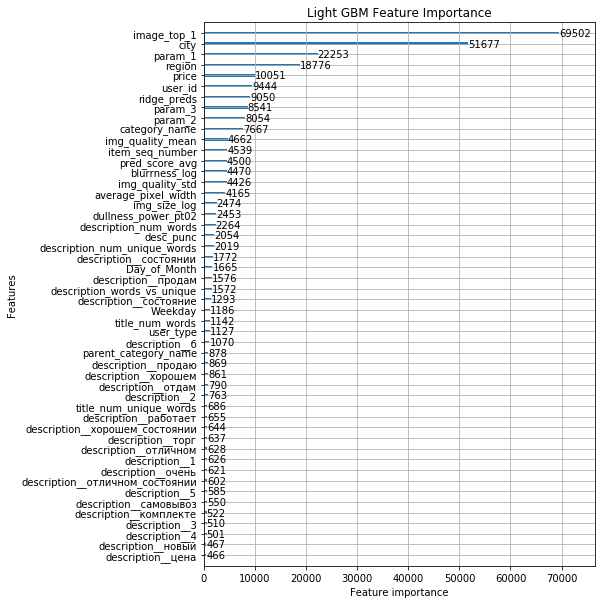

In [57]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()

In [60]:
# plt.savefig('feature_importance_by_public_model_stratified.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 
 
#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub_YEAHYEAHYEAHHHHHHH.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Model Evaluation Stage


/home/user/san/project_p/LightGBM/python-package/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Notebook Runtime: 75.32 Minutes


In [26]:
lgsub.head(100)

,deal_probability
item_id,
6544e41a8817,0.286540
65b9484d670f,0.113667
8bab230b2ecd,0.152080
8e348601fefc,0.114624
8bd2fe400b89,0.285761
c63dbd6c657f,0.057007
6d1a410df86e,0.004078
e8d3e7922b80,0.013810
2bc1ab208462,0.049071
